In [ ]:
from pytorch_lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
from pytorch_lightning.strategies import DDPStrategy
from time import perf_counter
import wandb
import numpy as np

from src.algorithms.unrolling_policy_iteration import UnrollingPolicyIterationTrain
from src.environments import CliffWalkingEnv, MirroredCliffWalkingEnv
from src.algorithms.generalized_policy_iteration import PolicyIterationTrain
from src.utils import get_optimal_q, test_pol_err, plot_errors, save_error_matrix_to_csv

SAVE = True
PATH = "results/transfer/"

## Auxiliary functions

In [ ]:
def run(g, N_unrolls, Exps, q_opt, q_opt_mirr, group_name, use_logger=True, log_every_n_steps=1, verbose=False):
    err = np.zeros((len(Exps), N_unrolls.size))
    err_tranf = np.zeros((len(Exps), N_unrolls.size))
    bell_err_tranf = np.zeros((len(Exps), N_unrolls.size))
    
    use_logger = use_logger and g == 0

    for i, n_unrolls in enumerate(N_unrolls):
        n_unrolls = int(n_unrolls)
        for j, exp in enumerate(Exps):
            env = CliffWalkingEnv()
            mirror_env = MirroredCliffWalkingEnv()
            if exp["model"] == "unroll":
                model = UnrollingPolicyIterationTrain(env=env, mirror_env=mirror_env, num_unrolls=n_unrolls, **exp["args"])
                if use_logger:
                    logger = WandbLogger(project="rl-unrolling", name=f"{exp['name']}-{n_unrolls}unrolls",
                                         group=group_name)
                else:
                    logger = False
                trainer = Trainer(max_epochs=3000, log_every_n_steps=log_every_n_steps, accelerator="cpu", logger=logger)

                trainer.fit(model)
                wandb.finish()

                _, err[j,i] = test_pol_err(model.Pi, q_opt, mirror_env=False, device=model.device)
                _, err_tranf[j,i] = test_pol_err(model.Pi_test, q_opt_mirr, mirror_env=True, device=model.device)
                bell_err_tranf[j,i] = model.bellman_error_test.cpu().numpy()

            elif exp["model"] == "pol-it":
                model = PolicyIterationTrain(env=mirror_env, goal_row=0, **exp["args"])
                if use_logger:
                    logger = WandbLogger(project="rl-unrolling", name=f"{exp['name']}-{n_unrolls}impr",
                                         group=group_name)
                else:
                    logger = False
                trainer = Trainer(max_epochs=n_unrolls, log_every_n_steps=log_every_n_steps, accelerator='cpu', logger=logger)

                trainer.fit(model)
                wandb.finish()

                _, err[j,i] = test_pol_err(model.Pi, q_opt_mirr, mirror_env=True, device=model.device)
                err_tranf[j,i] = err[j,i]
                bell_err_tranf[j,i] = model.bellman_error.cpu().numpy()
                
            else:
                raise Exception("Unknown model")

            if verbose:
                print(f"- {g}. Unrolls {n_unrolls}: Model: {exp['name']} Err: {err[j,i]:.3f} | Err tranf: {err_tranf[j,i]:.3f} | bell_err: {bell_err_tranf[j,i]:.3f}")
    return err, err_tranf, bell_err_tranf


## K = 5

In [ ]:
verbose = True
use_logger = True
log_every_n_steps = 1
K = 5
group_name = f"transfer-K{K}"

N_unrolls = np.arange(2,16, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},


    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(mirror_env=False, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)
q_opt_mirr = get_optimal_q(mirror_env=True, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
wandb: Currently logged in as: samuel-rey (samuel-rey-lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=yuux, bellman_error=0.000, policy_diff=2.000, q_norm=732.0]             

/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 107.68it/s, v_num=yuux, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 70.47it/s, v_num=yuux, bellman_error=0.000, policy_diff=0.000, q_norm=709.0] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
policy_diff,█▆▄▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
q_norm,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
bellman_error,0
epoch,49
policy_diff,0
q_norm,708.56281
trainer/global_step,49


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 136.00it/s, v_num=yys8, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 86.91it/s, v_num=yys8, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
policy_diff,██▅▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
q_norm,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
bellman_error,0
epoch,49
policy_diff,0
q_norm,1076.57019
trainer/global_step,49


In [ ]:
n_runs = 5

errs = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs_trans = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs[g], errs_trans[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, q_opt_mirr, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs=errs, errs_trans=errs_trans, bell_errs=bell_errs)
    print("Data saved as:", file_name)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 155.32it/s, v_num=7sdh, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.98it/s, v_num=7sdh, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁█
epoch,▁█
policy_diff,█▁
q_norm,▁█
trainer/global_step,▁██
bellman_error,0.48132
epoch,1
policy_diff,4.47214
q_norm,962.44452
trainer/global_step,1


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 169.82it/s, v_num=80ov, bellman_error=0.0221, policy_diff=6.320, q_norm=1.26e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 101.47it/s, v_num=80ov, bellman_error=0.0221, policy_diff=6.320, q_norm=1.26e+3]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁
epoch,▁█
policy_diff,▁█
q_norm,█▁
trainer/global_step,▁██
bellman_error,0.02214
epoch,1
policy_diff,6.32456
q_norm,1256.98108
trainer/global_step,1


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: pol-it-5eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.022


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 138.14it/s, v_num=w1lt, bellman_error=0.00596, policy_diff=5.660, q_norm=1.9e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 88.69it/s, v_num=w1lt, bellman_error=0.00596, policy_diff=5.660, q_norm=1.9e+3] 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁
epoch,▁█
policy_diff,█▁
q_norm,█▁
trainer/global_step,▁██
bellman_error,0.00596
epoch,1
policy_diff,5.65685
q_norm,1904.64233
trainer/global_step,1


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: pol-it-10eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.006


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 166.28it/s, v_num=bfqe, bellman_error=0.000651, policy_diff=6.160, q_norm=2.31e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 102.03it/s, v_num=bfqe, bellman_error=0.000651, policy_diff=6.160, q_norm=2.31e+3]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁
epoch,▁█
policy_diff,█▁
q_norm,█▁
trainer/global_step,▁██
bellman_error,0.00065
epoch,1
policy_diff,6.16441
q_norm,2312.45312
trainer/global_step,1


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: pol-it-15eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.001


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 148.19it/s, v_num=o6xg, bellman_error=0.00886, policy_diff=6.320, q_norm=3.44e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 92.93it/s, v_num=o6xg, bellman_error=0.00886, policy_diff=6.320, q_norm=3.44e+3] 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁
epoch,▁█
policy_diff,▁█
q_norm,█▁
trainer/global_step,▁██
bellman_error,0.00886
epoch,1
policy_diff,6.32456
q_norm,3442.91406
trainer/global_step,1


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: pol-it-20eval Err: 0.039 | Err tranf: 0.039 | bell_err: 0.009


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 158.36it/s, v_num=rhd9, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 96.26it/s, v_num=rhd9, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▆█▁▁
epoch,▁▃▆█
policy_diff,█▆▁▁
q_norm,▁▆▇█
trainer/global_step,▁▃▆██
bellman_error,0.01249
epoch,3
policy_diff,0
q_norm,981.5705
trainer/global_step,3


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 160.95it/s, v_num=wy8a, bellman_error=0.00538, policy_diff=2.450, q_norm=1.27e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 99.49it/s, v_num=wy8a, bellman_error=0.00538, policy_diff=2.450, q_norm=1.27e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▂▁▁
epoch,▁▃▆█
policy_diff,█▇▁▁
q_norm,█▁▁▂
trainer/global_step,▁▃▆██
bellman_error,0.00538
epoch,3
policy_diff,2.44949
q_norm,1269.34802
trainer/global_step,3


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 4: Model: pol-it-5eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.005


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 153.97it/s, v_num=cdbk, bellman_error=0.000169, policy_diff=2.450, q_norm=1.97e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 96.24it/s, v_num=cdbk, bellman_error=0.000169, policy_diff=2.450, q_norm=1.97e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▄▁▁
epoch,▁▃▆█
policy_diff,▇█▂▁
q_norm,█▃▁▁
trainer/global_step,▁▃▆██
bellman_error,0.00017
epoch,3
policy_diff,2.44949
q_norm,1970.21191
trainer/global_step,3


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 149.67it/s, v_num=n2z5, bellman_error=0.00315, policy_diff=2.450, q_norm=2.92e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 87.16it/s, v_num=n2z5, bellman_error=0.00315, policy_diff=2.450, q_norm=2.92e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁
epoch,▁▃▆█
policy_diff,█▅▃▁
q_norm,█▃▂▁
trainer/global_step,▁▃▆██
bellman_error,0.00315
epoch,3
policy_diff,2.44949
q_norm,2916.39722
trainer/global_step,3


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 4: Model: pol-it-15eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.003


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 128.63it/s, v_num=rxep, bellman_error=0.000804, policy_diff=2.450, q_norm=2.1e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 81.50it/s, v_num=rxep, bellman_error=0.000804, policy_diff=2.450, q_norm=2.1e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁
epoch,▁▃▆█
policy_diff,█▇▂▁
q_norm,█▄▂▁
trainer/global_step,▁▃▆██
bellman_error,0.0008
epoch,3
policy_diff,2.44949
q_norm,2103.96313
trainer/global_step,3


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 4: Model: pol-it-20eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.001


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 171.06it/s, v_num=te16, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 103.11it/s, v_num=te16, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▆█▁▁▁▁
epoch,▁▂▄▅▇█
policy_diff,█▆▁▁▁▁
q_norm,▁▅▆▇▇█
trainer/global_step,▁▂▄▅▇██
bellman_error,0.01149
epoch,5
policy_diff,0
q_norm,1000.45868
trainer/global_step,5


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 153.98it/s, v_num=qsq0, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 91.35it/s, v_num=qsq0, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▂▁▁▁▁
epoch,▁▂▄▅▇█
policy_diff,█▆▄▄▃▁
q_norm,█▃▃▃▂▁
trainer/global_step,▁▂▄▅▇██
bellman_error,0
epoch,5
policy_diff,0
q_norm,1076.57019
trainer/global_step,5


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 6: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 156.78it/s, v_num=dcsv, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 97.02it/s, v_num=dcsv, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▂▁▁▁▁
epoch,▁▂▄▅▇█
policy_diff,██▅▄▃▁
q_norm,█▆▅▅▃▁
trainer/global_step,▁▂▄▅▇██
bellman_error,0
epoch,5
policy_diff,0
q_norm,1076.57019
trainer/global_step,5


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 166.88it/s, v_num=n6bf, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 104.79it/s, v_num=n6bf, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁▁▁
epoch,▁▂▄▅▇█
policy_diff,██▄▃▁▁
q_norm,█▆▅▃▁▁
trainer/global_step,▁▂▄▅▇██
bellman_error,0
epoch,5
policy_diff,0
q_norm,1076.57019
trainer/global_step,5


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 147.14it/s, v_num=wc7s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 92.59it/s, v_num=wc7s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▂▂▂▁▁
epoch,▁▂▄▅▇█
policy_diff,█▆▄▃▁▁
q_norm,█▆▅▃▁▁
trainer/global_step,▁▂▄▅▇██
bellman_error,0
epoch,5
policy_diff,0
q_norm,1076.57019
trainer/global_step,5


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 166.55it/s, v_num=wurc, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 103.78it/s, v_num=wurc, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▇█▁▁▁▁▁▁
epoch,▁▂▃▄▅▆▇█
policy_diff,█▆▁▁▁▁▁▁
q_norm,▁▅▅▆▆▇▇█
trainer/global_step,▁▂▃▄▅▆▇██
bellman_error,0.01054
epoch,7
policy_diff,0
q_norm,1019.02228
trainer/global_step,7


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 155.18it/s, v_num=jr17, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 96.75it/s, v_num=jr17, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▂▆▁▁▁▁▁
epoch,▁▂▃▄▅▆▇█
policy_diff,█▇▄▃▃▁▁▁
q_norm,█▅▅▅▃▁▁▁
trainer/global_step,▁▂▃▄▅▆▇██
bellman_error,0
epoch,7
policy_diff,0
q_norm,1076.57019
trainer/global_step,7


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 147.15it/s, v_num=p5ns, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 92.63it/s, v_num=p5ns, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▂▁▁▁▁▁▁
epoch,▁▂▃▄▅▆▇█
policy_diff,██▆▄▄▃▁▁
q_norm,█▇▆▆▆▄▁▁
trainer/global_step,▁▂▃▄▅▆▇██
bellman_error,0
epoch,7
policy_diff,0
q_norm,1076.57019
trainer/global_step,7


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 163.70it/s, v_num=uvdn, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 100.59it/s, v_num=uvdn, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁▁▁▁▁
epoch,▁▂▃▄▅▆▇█
policy_diff,█▅▄▃▁▁▁▁
q_norm,█▅▄▃▁▁▁▁
trainer/global_step,▁▂▃▄▅▆▇██
bellman_error,0
epoch,7
policy_diff,0
q_norm,1076.57019
trainer/global_step,7


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 150.94it/s, v_num=1jtw, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 94.54it/s, v_num=1jtw, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▂▂▂▁▁▁▁
epoch,▁▂▃▄▅▆▇█
policy_diff,█▅▄▄▁▁▁▁
q_norm,█▅▄▄▁▁▁▁
trainer/global_step,▁▂▃▄▅▆▇██
bellman_error,0
epoch,7
policy_diff,0
q_norm,1076.57019
trainer/global_step,7


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 170.19it/s, v_num=rrh3, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 105.14it/s, v_num=rrh3, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▆█▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
policy_diff,█▆▁▁▁▁▁▁▁▁
q_norm,▁▄▅▅▆▆▇▇██
trainer/global_step,▁▂▃▃▄▅▆▆▇██
bellman_error,0.00963
epoch,9
policy_diff,0
q_norm,1037.16748
trainer/global_step,9


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 165.84it/s, v_num=w3v6, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 102.73it/s, v_num=w3v6, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▃▇▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
policy_diff,█▇▄▃▃▁▁▁▁▁
q_norm,█▃▂▃▂▁▁▁▁▁
trainer/global_step,▁▂▃▃▄▅▆▆▇██
bellman_error,0
epoch,9
policy_diff,0
q_norm,1076.57019
trainer/global_step,9


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 122.75it/s, v_num=n5pc, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 81.27it/s, v_num=n5pc, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
policy_diff,██▄▄▃▁▁▁▁▁
q_norm,█▆▆▆▄▁▁▁▁▁
trainer/global_step,▁▂▃▃▄▅▆▆▇██
bellman_error,0
epoch,9
policy_diff,0
q_norm,1076.57019
trainer/global_step,9


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 174.31it/s, v_num=qlh6, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 108.70it/s, v_num=qlh6, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▃▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
policy_diff,█▆▄▄▃▁▁▁▁▁
q_norm,█▅▅▄▃▁▁▁▁▁
trainer/global_step,▁▂▃▃▄▅▆▆▇██
bellman_error,0
epoch,9
policy_diff,0
q_norm,1076.57019
trainer/global_step,9


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 145.80it/s, v_num=ncsw, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 91.86it/s, v_num=ncsw, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▃▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
policy_diff,█▇▅▁▁▁▁▁▁▁
q_norm,█▆▃▁▁▁▁▁▁▁
trainer/global_step,▁▂▃▃▄▅▆▆▇██
bellman_error,0
epoch,9
policy_diff,0
q_norm,1076.57019
trainer/global_step,9


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/srey/Investigacion/rl-unrolling/checkpoints exists and is not empty.

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 185.97it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 84.71it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



- 1. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 181.55it/s, bellman_error=0.0169, policy_diff=6.480, q_norm=1.25e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 83.87it/s, bellman_error=0.0169, policy_diff=6.480, q_norm=1.25e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: pol-it-5eval Err: 0.068 | Err tranf: 0.068 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 179.97it/s, bellman_error=0.0283, policy_diff=5.830, q_norm=2.74e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 84.37it/s, bellman_error=0.0283, policy_diff=5.830, q_norm=2.74e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 1. Unrolls 2: Model: pol-it-10eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.028



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 149.09it/s, bellman_error=0.00325, policy_diff=5.660, q_norm=2.95e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 72.17it/s, bellman_error=0.00325, policy_diff=5.660, q_norm=2.95e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 1. Unrolls 2: Model: pol-it-15eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.003



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 174.60it/s, bellman_error=0.00151, policy_diff=5.100, q_norm=2.67e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 81.97it/s, bellman_error=0.00151, policy_diff=5.100, q_norm=2.67e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: pol-it-20eval Err: 0.078 | Err tranf: 0.078 | bell_err: 0.002
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 183.96it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 85.47it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 1. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 179.43it/s, bellman_error=0.00681, policy_diff=2.000, q_norm=1.16e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 83.98it/s, bellman_error=0.00681, policy_diff=2.000, q_norm=1.16e+3] 
- 1. Unrolls 4: Model: pol-it-5eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.007


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 169.82it/s, bellman_error=0.000984, policy_diff=2.450, q_norm=2.14e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 82.26it/s, bellman_error=0.000984, policy_diff=2.450, q_norm=2.14e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.001
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 174.56it/s, bellman_error=0.00273, policy_diff=2.450, q_norm=2.65e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 81.89it/s, bellman_error=0.00273, policy_diff=2.450, q_norm=2.65e+3] 
- 1. Unrolls 4: Model: pol-it-15eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.003


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 167.91it/s, bellman_error=0.00266, policy_diff=2.830, q_norm=2.73e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 79.67it/s, bellman_error=0.00266, policy_diff=2.830, q_norm=2.73e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 1. Unrolls 4: Model: pol-it-20eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.003



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 160.99it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 80.44it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011
Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 179.09it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 84.29it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 1. Unrolls 6: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 176.65it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 82.70it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 1. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 172.63it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 77.61it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 1. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 169.72it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 80.96it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 1. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 180.03it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 85.56it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 1. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 175.95it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 83.31it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 1. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 178.34it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 87.68it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 1. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 81.12it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 1. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 175.43it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 87.10it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 1. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 192.78it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 63.53it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 1. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 196.11it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 64.48it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 1. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 188.95it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 59.50it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 1. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 185.54it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 60.76it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 1. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 189.67it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 63.20it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 1. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 188.65it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 90.34it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 2. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 187.64it/s, bellman_error=0.0253, policy_diff=5.100, q_norm=1.32e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 90.08it/s, bellman_error=0.0253, policy_diff=5.100, q_norm=1.32e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 2. Unrolls 2: Model: pol-it-5eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.025
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 186.18it/s, bellman_error=0.0126, policy_diff=5.480, q_norm=3.43e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 88.70it/s, bellman_error=0.0126, policy_diff=5.480, q_norm=3.43e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 2. Unrolls 2: Model: pol-it-10eval Err: 0.039 | Err tranf: 0.039 | bell_err: 0.013



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 180.80it/s, bellman_error=0.0115, policy_diff=5.660, q_norm=3.66e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 89.90it/s, bellman_error=0.0115, policy_diff=5.660, q_norm=3.66e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 2. Unrolls 2: Model: pol-it-15eval Err: 0.039 | Err tranf: 0.039 | bell_err: 0.012
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 173.57it/s, bellman_error=0.00565, policy_diff=6.000, q_norm=4.39e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 87.01it/s, bellman_error=0.00565, policy_diff=6.000, q_norm=4.39e+3] 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 2. Unrolls 2: Model: pol-it-20eval Err: 0.039 | Err tranf: 0.039 | bell_err: 0.006
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 195.75it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 92.45it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 2. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 176.57it/s, bellman_error=0.0395, policy_diff=2.000, q_norm=1.32e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 85.23it/s, bellman_error=0.0395, policy_diff=2.000, q_norm=1.32e+3] 
- 2. Unrolls 4: Model: pol-it-5eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.040

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 178.77it/s, bellman_error=0.000343, policy_diff=2.000, q_norm=1.87e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 82.95it/s, bellman_error=0.000343, policy_diff=2.000, q_norm=1.87e+3] 
- 2. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 167.57it/s, bellman_error=0.00369, policy_diff=2.000, q_norm=2.43e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 80.34it/s, bellman_error=0.00369, policy_diff=2.000, q_norm=2.43e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 2. Unrolls 4: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.004
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 172.97it/s, bellman_error=0.00314, policy_diff=2.000, q_norm=2.25e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 78.31it/s, bellman_error=0.00314, policy_diff=2.000, q_norm=2.25e+3] 
- 2. Unrolls 4: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.003


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 166.84it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 78.73it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 
- 2. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 151.56it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 75.23it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 2. Unrolls 6: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 154.97it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 75.65it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 2. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 157.51it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 76.64it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 2. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 151.35it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 71.86it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 2. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 173.05it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 81.82it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 2. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 171.71it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 80.02it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 2. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 169.15it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 79.59it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 2. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 164.77it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 78.58it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 2. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 160.68it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 77.27it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 2. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 171.84it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.47it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 2. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 173.05it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.11it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 2. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 168.01it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 56.95it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 2. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 183.61it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 60.16it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 2. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 174.28it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.41it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 2. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 176.18it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 79.56it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 3. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 178.43it/s, bellman_error=0.0268, policy_diff=5.830, q_norm=1.32e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 83.40it/s, bellman_error=0.0268, policy_diff=5.830, q_norm=1.32e+3] 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 3. Unrolls 2: Model: pol-it-5eval Err: 0.068 | Err tranf: 0.068 | bell_err: 0.027
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 186.41it/s, bellman_error=0.00981, policy_diff=6.000, q_norm=2.37e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 84.53it/s, bellman_error=0.00981, policy_diff=6.000, q_norm=2.37e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 3. Unrolls 2: Model: pol-it-10eval Err: 0.084 | Err tranf: 0.084 | bell_err: 0.010
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 171.86it/s, bellman_error=0.00998, policy_diff=6.000, q_norm=2.97e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 81.24it/s, bellman_error=0.00998, policy_diff=6.000, q_norm=2.97e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 3. Unrolls 2: Model: pol-it-15eval Err: 0.078 | Err tranf: 0.078 | bell_err: 0.010
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 178.62it/s, bellman_error=0.00735, policy_diff=5.480, q_norm=2.94e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 86.47it/s, bellman_error=0.00735, policy_diff=5.480, q_norm=2.94e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 3. Unrolls 2: Model: pol-it-20eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.007



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 181.40it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 82.07it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 
- 3. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 184.71it/s, bellman_error=0.00307, policy_diff=2.450, q_norm=1.49e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s, bellman_error=0.00307, policy_diff=2.450, q_norm=1.49e+3] 
- 3. Unrolls 4: Model: pol-it-5eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.003


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 169.02it/s, bellman_error=0.00243, policy_diff=2.450, q_norm=1.56e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 82.56it/s, bellman_error=0.00243, policy_diff=2.450, q_norm=1.56e+3] 
- 3. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.002


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 179.33it/s, bellman_error=0.00201, policy_diff=2.450, q_norm=2.41e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 85.11it/s, bellman_error=0.00201, policy_diff=2.450, q_norm=2.41e+3] 
- 3. Unrolls 4: Model: pol-it-15eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.002


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 150.59it/s, bellman_error=0.00268, policy_diff=2.000, q_norm=2.12e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 78.03it/s, bellman_error=0.00268, policy_diff=2.000, q_norm=2.12e+3] 
- 3. Unrolls 4: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.003


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 178.42it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 82.19it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 
- 3. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 162.65it/s, bellman_error=0.00481, policy_diff=2.000, q_norm=1.32e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 82.35it/s, bellman_error=0.00481, policy_diff=2.000, q_norm=1.32e+3] 
- 3. Unrolls 6: Model: pol-it-5eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.005


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 148.86it/s, bellman_error=0.00049, policy_diff=2.000, q_norm=1.67e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 77.55it/s, bellman_error=0.00049, policy_diff=2.000, q_norm=1.67e+3] 
- 3. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 165.95it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 83.06it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 3. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 83.58it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 3. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 167.47it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 79.45it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 3. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 184.71it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 87.63it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 3. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 183.29it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 86.37it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 3. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 169.00it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 79.35it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 3. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 176.57it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 84.74it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 3. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 172.84it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.00it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 3. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 169.44it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.34it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 3. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 169.06it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.17it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 3. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 174.84it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.61it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 3. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 167.52it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.75it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 3. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 144.82it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 72.48it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 
- 4. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 165.20it/s, bellman_error=0.0579, policy_diff=5.290, q_norm=1.3e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 77.19it/s, bellman_error=0.0579, policy_diff=5.290, q_norm=1.3e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 4. Unrolls 2: Model: pol-it-5eval Err: 0.068 | Err tranf: 0.068 | bell_err: 0.058



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 158.80it/s, bellman_error=0.0115, policy_diff=4.690, q_norm=1.63e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 76.64it/s, bellman_error=0.0115, policy_diff=4.690, q_norm=1.63e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 4. Unrolls 2: Model: pol-it-10eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.011
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 160.95it/s, bellman_error=0.00416, policy_diff=4.240, q_norm=3.38e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 77.40it/s, bellman_error=0.00416, policy_diff=4.240, q_norm=3.38e+3] 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores



- 4. Unrolls 2: Model: pol-it-15eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.004


HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 160.41it/s, bellman_error=0.00419, policy_diff=5.480, q_norm=3.4e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 77.12it/s, bellman_error=0.00419, policy_diff=5.480, q_norm=3.4e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 4. Unrolls 2: Model: pol-it-20eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.004
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 173.63it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 79.35it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 
- 4. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 151.55it/s, bellman_error=0.00475, policy_diff=2.830, q_norm=1.38e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 74.53it/s, bellman_error=0.00475, policy_diff=2.830, q_norm=1.38e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 4. Unrolls 4: Model: pol-it-5eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.005



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 163.13it/s, bellman_error=0.00208, policy_diff=2.450, q_norm=1.61e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 77.51it/s, bellman_error=0.00208, policy_diff=2.450, q_norm=1.61e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 4. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.002



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 165.03it/s, bellman_error=0.00263, policy_diff=2.450, q_norm=2.61e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 76.19it/s, bellman_error=0.00263, policy_diff=2.450, q_norm=2.61e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 4. Unrolls 4: Model: pol-it-15eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.003



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 163.54it/s, bellman_error=0.00268, policy_diff=4.000, q_norm=2.63e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 78.16it/s, bellman_error=0.00268, policy_diff=4.000, q_norm=2.63e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 4. Unrolls 4: Model: pol-it-20eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.003



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 149.48it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 74.19it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 
- 4. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 156.39it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 74.91it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 4. Unrolls 6: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 153.06it/s, bellman_error=0.000297, policy_diff=2.000, q_norm=1.64e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 74.83it/s, bellman_error=0.000297, policy_diff=2.000, q_norm=1.64e+3] 
- 4. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 163.68it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 77.77it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 4. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 155.20it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 71.51it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 4. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 173.16it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 80.92it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 4. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 169.33it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 80.20it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 4. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 168.07it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 79.29it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 4. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 167.15it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 79.58it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 4. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 163.14it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 77.81it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 4. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 172.46it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.07it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 4. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 160.89it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 4. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 161.52it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 54.97it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 4. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 164.37it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 54.52it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 4. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 150.30it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 54.81it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 4. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 153.93it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 75.54it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 
- 5. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 161.89it/s, bellman_error=0.032, policy_diff=6.160, q_norm=1.15e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 77.79it/s, bellman_error=0.032, policy_diff=6.160, q_norm=1.15e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 5. Unrolls 2: Model: pol-it-5eval Err: 0.078 | Err tranf: 0.078 | bell_err: 0.032



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 167.93it/s, bellman_error=0.022, policy_diff=6.160, q_norm=2.51e+3] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 76.72it/s, bellman_error=0.022, policy_diff=6.160, q_norm=2.51e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


- 5. Unrolls 2: Model: pol-it-10eval Err: 0.058 | Err tranf: 0.058 | bell_err: 0.022


HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 160.14it/s, bellman_error=0.00814, policy_diff=4.900, q_norm=3.04e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 76.88it/s, bellman_error=0.00814, policy_diff=4.900, q_norm=3.04e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 5. Unrolls 2: Model: pol-it-15eval Err: 0.058 | Err tranf: 0.058 | bell_err: 0.008



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 146.40it/s, bellman_error=0.00486, policy_diff=4.690, q_norm=3.21e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 72.14it/s, bellman_error=0.00486, policy_diff=4.690, q_norm=3.21e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 5. Unrolls 2: Model: pol-it-20eval Err: 0.058 | Err tranf: 0.058 | bell_err: 0.005



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 169.30it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 78.26it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 
- 5. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 164.12it/s, bellman_error=0.0437, policy_diff=2.000, q_norm=1.36e+3] 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 76.45it/s, bellman_error=0.0437, policy_diff=2.000, q_norm=1.36e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 5. Unrolls 4: Model: pol-it-5eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.044



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 158.00it/s, bellman_error=0.000249, policy_diff=2.450, q_norm=1.99e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 75.40it/s, bellman_error=0.000249, policy_diff=2.450, q_norm=1.99e+3] 
- 5. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 164.21it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=2.52e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 78.69it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=2.52e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 5. Unrolls 4: Model: pol-it-15eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.002



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 164.20it/s, bellman_error=0.00418, policy_diff=2.000, q_norm=2.62e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 77.22it/s, bellman_error=0.00418, policy_diff=2.000, q_norm=2.62e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 5. Unrolls 4: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.004



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 157.24it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 77.67it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 5. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011
Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 154.85it/s, bellman_error=0.00497, policy_diff=2.450, q_norm=1.3e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 75.19it/s, bellman_error=0.00497, policy_diff=2.450, q_norm=1.3e+3] 
- 5. Unrolls 6: Model: pol-it-5eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.005


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 154.74it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 75.11it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 5. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 160.58it/s, bellman_error=0.00233, policy_diff=2.000, q_norm=2.03e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 75.81it/s, bellman_error=0.00233, policy_diff=2.000, q_norm=2.03e+3] 
- 5. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.002


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 160.22it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 75.47it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 5. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 166.37it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 77.83it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 5. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 168.22it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 75.97it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 5. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 178.24it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 83.77it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 5. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 176.60it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 81.01it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 5. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 172.95it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 82.03it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 5. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 182.42it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 59.73it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 5. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 173.85it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.89it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 5. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 153.91it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.06it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 5. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 184.61it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 59.57it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 5. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 159.22it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 43.40it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 5. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 175.75it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 79.47it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 6. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 146.72it/s, bellman_error=0.0796, policy_diff=4.900, q_norm=1.32e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 72.01it/s, bellman_error=0.0796, policy_diff=4.900, q_norm=1.32e+3] 
- 6. Unrolls 2: Model: pol-it-5eval Err: 0.058 | Err tranf: 0.058 | bell_err: 0.080


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 152.14it/s, bellman_error=0.0219, policy_diff=4.470, q_norm=2.69e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 75.53it/s, bellman_error=0.0219, policy_diff=4.470, q_norm=2.69e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 6. Unrolls 2: Model: pol-it-10eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.022



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 165.38it/s, bellman_error=0.00187, policy_diff=6.480, q_norm=2.46e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 80.81it/s, bellman_error=0.00187, policy_diff=6.480, q_norm=2.46e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 6. Unrolls 2: Model: pol-it-15eval Err: 0.064 | Err tranf: 0.064 | bell_err: 0.002



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 176.05it/s, bellman_error=0.00499, policy_diff=5.290, q_norm=3.97e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 75.29it/s, bellman_error=0.00499, policy_diff=5.290, q_norm=3.97e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 6. Unrolls 2: Model: pol-it-20eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.005



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 185.66it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 83.39it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 6. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 168.62it/s, bellman_error=0.00455, policy_diff=2.000, q_norm=1.34e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 77.87it/s, bellman_error=0.00455, policy_diff=2.000, q_norm=1.34e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 6. Unrolls 4: Model: pol-it-5eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.005



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 160.53it/s, bellman_error=0.000671, policy_diff=2.450, q_norm=2.07e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 75.39it/s, bellman_error=0.000671, policy_diff=2.450, q_norm=2.07e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 6. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.001
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 163.77it/s, bellman_error=0.00238, policy_diff=2.000, q_norm=2.04e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 77.53it/s, bellman_error=0.00238, policy_diff=2.000, q_norm=2.04e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 6. Unrolls 4: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.002



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 160.81it/s, bellman_error=0.00345, policy_diff=3.160, q_norm=3.04e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 73.78it/s, bellman_error=0.00345, policy_diff=3.160, q_norm=3.04e+3] 


GPU available: True (cuda), used: False


- 6. Unrolls 4: Model: pol-it-20eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.003


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 159.55it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 74.08it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 
- 6. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 149.33it/s, bellman_error=0.00244, policy_diff=2.000, q_norm=1.32e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 66.19it/s, bellman_error=0.00244, policy_diff=2.000, q_norm=1.32e+3] 
- 6. Unrolls 6: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.002


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 144.24it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 71.28it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 6. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 160.44it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 76.27it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 6. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 154.11it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 74.52it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 6. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 171.88it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 79.85it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 6. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 188.62it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 82.43it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 6. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 192.33it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 87.70it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 6. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 185.22it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 88.10it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 6. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 178.85it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 86.96it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 6. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 195.52it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 62.71it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 6. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 195.09it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 61.09it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 6. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 190.25it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 61.72it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 6. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 191.42it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 61.55it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 6. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 188.95it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 60.78it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 6. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 187.19it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 83.80it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



- 7. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 193.27it/s, bellman_error=0.018, policy_diff=5.480, q_norm=1.23e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 87.91it/s, bellman_error=0.018, policy_diff=5.480, q_norm=1.23e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 7. Unrolls 2: Model: pol-it-5eval Err: 0.058 | Err tranf: 0.058 | bell_err: 0.018
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 177.26it/s, bellman_error=0.0162, policy_diff=5.830, q_norm=2.13e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 70.88it/s, bellman_error=0.0162, policy_diff=5.830, q_norm=2.13e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 7. Unrolls 2: Model: pol-it-10eval Err: 0.078 | Err tranf: 0.078 | bell_err: 0.016
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 180.45it/s, bellman_error=0.00734, policy_diff=6.320, q_norm=4.23e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 83.68it/s, bellman_error=0.00734, policy_diff=6.320, q_norm=4.23e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 7. Unrolls 2: Model: pol-it-15eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.007
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 179.52it/s, bellman_error=7.41e-5, policy_diff=6.160, q_norm=2.02e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 83.56it/s, bellman_error=7.41e-5, policy_diff=6.160, q_norm=2.02e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 7. Unrolls 2: Model: pol-it-20eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.000
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 191.97it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 88.89it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 
- 7. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 182.19it/s, bellman_error=0.152, policy_diff=1.410, q_norm=1.39e+3] 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 87.02it/s, bellman_error=0.152, policy_diff=1.410, q_norm=1.39e+3] 
- 7. Unrolls 4: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.152


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 190.27it/s, bellman_error=0.000377, policy_diff=2.450, q_norm=2.01e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 88.90it/s, bellman_error=0.000377, policy_diff=2.450, q_norm=2.01e+3] 
- 7. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 184.53it/s, bellman_error=0.00218, policy_diff=2.450, q_norm=2.47e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 86.49it/s, bellman_error=0.00218, policy_diff=2.450, q_norm=2.47e+3] 
- 7. Unrolls 4: Model: pol-it-15eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.002


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 182.05it/s, bellman_error=0.00294, policy_diff=2.450, q_norm=2.73e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 86.04it/s, bellman_error=0.00294, policy_diff=2.450, q_norm=2.73e+3] 
- 7. Unrolls 4: Model: pol-it-20eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.003


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 193.25it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 88.97it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 
- 7. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 169.56it/s, bellman_error=0.00467, policy_diff=2.000, q_norm=1.33e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 80.51it/s, bellman_error=0.00467, policy_diff=2.000, q_norm=1.33e+3] 
- 7. Unrolls 6: Model: pol-it-5eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.005


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 184.00it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 86.24it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 7. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 186.21it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 87.73it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 7. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 186.87it/s, bellman_error=0.000566, policy_diff=2.000, q_norm=1.69e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 87.49it/s, bellman_error=0.000566, policy_diff=2.000, q_norm=1.69e+3] 
- 7. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.001


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 195.51it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 88.34it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 7. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 194.53it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 89.10it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 7. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 187.35it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 87.67it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 7. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 191.27it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 88.82it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 7. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 188.51it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 87.07it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 7. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 196.99it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 62.43it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 7. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 193.60it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 61.70it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 7. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 189.09it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 60.77it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 7. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 193.54it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 63.12it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 7. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 185.37it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 61.34it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 7. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 179.14it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 83.87it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 8. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 187.63it/s, bellman_error=0.0553, policy_diff=5.100, q_norm=1.49e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 86.56it/s, bellman_error=0.0553, policy_diff=5.100, q_norm=1.49e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 8. Unrolls 2: Model: pol-it-5eval Err: 0.039 | Err tranf: 0.039 | bell_err: 0.055
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 188.58it/s, bellman_error=0.00798, policy_diff=6.000, q_norm=1.77e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 87.46it/s, bellman_error=0.00798, policy_diff=6.000, q_norm=1.77e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 8. Unrolls 2: Model: pol-it-10eval Err: 0.058 | Err tranf: 0.058 | bell_err: 0.008
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 185.12it/s, bellman_error=0.0188, policy_diff=4.470, q_norm=2.76e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 86.74it/s, bellman_error=0.0188, policy_diff=4.470, q_norm=2.76e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 8. Unrolls 2: Model: pol-it-15eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.019
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 189.80it/s, bellman_error=0.00488, policy_diff=5.660, q_norm=3.87e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 88.63it/s, bellman_error=0.00488, policy_diff=5.660, q_norm=3.87e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 8. Unrolls 2: Model: pol-it-20eval Err: 0.068 | Err tranf: 0.068 | bell_err: 0.005
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 192.90it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 86.20it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 
- 8. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 191.34it/s, bellman_error=0.00839, policy_diff=3.740, q_norm=1.36e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 86.99it/s, bellman_error=0.00839, policy_diff=3.740, q_norm=1.36e+3] 
- 8. Unrolls 4: Model: pol-it-5eval Err: 0.064 | Err tranf: 0.064 | bell_err: 0.008


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 190.73it/s, bellman_error=0.000779, policy_diff=2.450, q_norm=1.8e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 87.87it/s, bellman_error=0.000779, policy_diff=2.450, q_norm=1.8e+3] 
- 8. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.001


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 186.24it/s, bellman_error=0.000355, policy_diff=2.450, q_norm=1.87e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 86.90it/s, bellman_error=0.000355, policy_diff=2.450, q_norm=1.87e+3] 
- 8. Unrolls 4: Model: pol-it-15eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 186.10it/s, bellman_error=0.00446, policy_diff=2.450, q_norm=3.46e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 87.31it/s, bellman_error=0.00446, policy_diff=2.450, q_norm=3.46e+3] 
- 8. Unrolls 4: Model: pol-it-20eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.004


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 187.61it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 84.95it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 
- 8. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 176.13it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 78.41it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 8. Unrolls 6: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 171.90it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 75.41it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 8. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 174.19it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 79.49it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 8. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 171.87it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 76.08it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 8. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 185.11it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 82.67it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 8. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 180.11it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 80.69it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 8. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 177.28it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 80.55it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 8. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 179.20it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 82.35it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 8. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 162.37it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 76.30it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 8. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 184.99it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.42it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 8. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 182.81it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.10it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 8. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 176.19it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.53it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 8. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 174.62it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.23it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 8. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 173.35it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.92it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 8. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 158.98it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 72.78it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 
- 9. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 157.82it/s, bellman_error=0.0516, policy_diff=5.830, q_norm=1.34e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 73.74it/s, bellman_error=0.0516, policy_diff=5.830, q_norm=1.34e+3] 
- 9. Unrolls 2: Model: pol-it-5eval Err: 0.068 | Err tranf: 0.068 | bell_err: 0.052


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 159.33it/s, bellman_error=0.0181, policy_diff=5.290, q_norm=2.22e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 75.05it/s, bellman_error=0.0181, policy_diff=5.290, q_norm=2.22e+3] 
- 9. Unrolls 2: Model: pol-it-10eval Err: 0.054 | Err tranf: 0.054 | bell_err: 0.018


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 147.45it/s, bellman_error=0.00313, policy_diff=5.100, q_norm=2.93e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 71.92it/s, bellman_error=0.00313, policy_diff=5.100, q_norm=2.93e+3] 
- 9. Unrolls 2: Model: pol-it-15eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.003


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 152.27it/s, bellman_error=0.00107, policy_diff=4.240, q_norm=2.26e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 72.17it/s, bellman_error=0.00107, policy_diff=4.240, q_norm=2.26e+3] 
- 9. Unrolls 2: Model: pol-it-20eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.001


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 160.94it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 74.76it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 9. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 165.86it/s, bellman_error=0.00405, policy_diff=2.000, q_norm=1.43e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 77.65it/s, bellman_error=0.00405, policy_diff=2.000, q_norm=1.43e+3] 
- 9. Unrolls 4: Model: pol-it-5eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.004


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 163.21it/s, bellman_error=0.00147, policy_diff=2.450, q_norm=1.69e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 76.07it/s, bellman_error=0.00147, policy_diff=2.450, q_norm=1.69e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 9. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.001



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 156.31it/s, bellman_error=0.00235, policy_diff=2.000, q_norm=2.04e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 75.26it/s, bellman_error=0.00235, policy_diff=2.000, q_norm=2.04e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 9. Unrolls 4: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.002



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 162.37it/s, bellman_error=0.00133, policy_diff=2.000, q_norm=2.23e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 74.96it/s, bellman_error=0.00133, policy_diff=2.000, q_norm=2.23e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 9. Unrolls 4: Model: pol-it-20eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.001



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 150.49it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 72.40it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 
- 9. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 152.54it/s, bellman_error=0.00216, policy_diff=2.000, q_norm=1.35e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 74.03it/s, bellman_error=0.00216, policy_diff=2.000, q_norm=1.35e+3] 
- 9. Unrolls 6: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.002


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 157.33it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 75.85it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 9. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 157.51it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 75.63it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 9. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 145.51it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 72.58it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 9. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 172.08it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 78.32it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 9. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 169.98it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 77.75it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 9. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 167.75it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 77.34it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 9. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 165.10it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 77.43it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 9. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 161.43it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 76.18it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 9. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 173.28it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 56.98it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 9. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 171.60it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 56.81it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 9. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 161.11it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.69it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 9. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 162.71it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.74it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 9. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 162.16it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.74it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 9. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 170.21it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 74.98it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 10. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 169.19it/s, bellman_error=0.0433, policy_diff=6.320, q_norm=1.54e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 77.31it/s, bellman_error=0.0433, policy_diff=6.320, q_norm=1.54e+3] 


GPU available: True (cuda), used: False


- 10. Unrolls 2: Model: pol-it-5eval Err: 0.039 | Err tranf: 0.039 | bell_err: 0.043


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 150.74it/s, bellman_error=0.0273, policy_diff=5.100, q_norm=2.79e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 72.26it/s, bellman_error=0.0273, policy_diff=5.100, q_norm=2.79e+3] 
- 10. Unrolls 2: Model: pol-it-10eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.027


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 164.73it/s, bellman_error=0.00155, policy_diff=6.480, q_norm=1.96e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 74.97it/s, bellman_error=0.00155, policy_diff=6.480, q_norm=1.96e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 10. Unrolls 2: Model: pol-it-15eval Err: 0.058 | Err tranf: 0.058 | bell_err: 0.002



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 162.10it/s, bellman_error=0.00535, policy_diff=6.320, q_norm=2.77e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 75.49it/s, bellman_error=0.00535, policy_diff=6.320, q_norm=2.77e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 10. Unrolls 2: Model: pol-it-20eval Err: 0.058 | Err tranf: 0.058 | bell_err: 0.005



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 160.53it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 78.37it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 
- 10. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 167.81it/s, bellman_error=0.0416, policy_diff=2.000, q_norm=1.34e+3] 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 78.20it/s, bellman_error=0.0416, policy_diff=2.000, q_norm=1.34e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 10. Unrolls 4: Model: pol-it-5eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.042
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 177.52it/s, bellman_error=0.00277, policy_diff=2.450, q_norm=1.52e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 81.21it/s, bellman_error=0.00277, policy_diff=2.450, q_norm=1.52e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 10. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.003
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 163.11it/s, bellman_error=0.0114, policy_diff=3.160, q_norm=3.19e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 76.54it/s, bellman_error=0.0114, policy_diff=3.160, q_norm=3.19e+3] 
- 10. Unrolls 4: Model: pol-it-15eval Err: 0.039 | Err tranf: 0.039 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 165.23it/s, bellman_error=0.00116, policy_diff=2.000, q_norm=1.79e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 79.86it/s, bellman_error=0.00116, policy_diff=2.000, q_norm=1.79e+3] 
- 10. Unrolls 4: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.001


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 182.61it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 82.73it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 
- 10. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 168.58it/s, bellman_error=0.00361, policy_diff=2.000, q_norm=1.22e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 78.13it/s, bellman_error=0.00361, policy_diff=2.000, q_norm=1.22e+3] 
- 10. Unrolls 6: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.004


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 169.32it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 77.86it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 10. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 163.83it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 72.51it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 10. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 171.70it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 80.99it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 10. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 177.02it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 82.65it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 10. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 184.03it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 82.70it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 10. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 176.10it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 82.69it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 10. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 164.62it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 76.84it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 10. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 159.23it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 75.88it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 10. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 174.25it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.21it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 10. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 172.38it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.91it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 10. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 171.06it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 56.97it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 10. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 160.71it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 54.53it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 10. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 165.56it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 10. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 168.08it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 75.99it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 11. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 170.26it/s, bellman_error=0.0184, policy_diff=5.290, q_norm=1.51e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 76.41it/s, bellman_error=0.0184, policy_diff=5.290, q_norm=1.51e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 11. Unrolls 2: Model: pol-it-5eval Err: 0.089 | Err tranf: 0.089 | bell_err: 0.018



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 160.69it/s, bellman_error=0.00628, policy_diff=4.690, q_norm=3.02e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 74.68it/s, bellman_error=0.00628, policy_diff=4.690, q_norm=3.02e+3] 
- 11. Unrolls 2: Model: pol-it-10eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.006


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 158.90it/s, bellman_error=0.00297, policy_diff=5.480, q_norm=2.11e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 65.56it/s, bellman_error=0.00297, policy_diff=5.480, q_norm=2.11e+3] 
- 11. Unrolls 2: Model: pol-it-15eval Err: 0.089 | Err tranf: 0.089 | bell_err: 0.003


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 158.79it/s, bellman_error=0.00714, policy_diff=6.780, q_norm=3.48e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 74.90it/s, bellman_error=0.00714, policy_diff=6.780, q_norm=3.48e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 11. Unrolls 2: Model: pol-it-20eval Err: 0.058 | Err tranf: 0.058 | bell_err: 0.007
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 167.60it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 76.12it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 11. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 168.28it/s, bellman_error=0.00541, policy_diff=2.000, q_norm=1.32e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 75.54it/s, bellman_error=0.00541, policy_diff=2.000, q_norm=1.32e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 11. Unrolls 4: Model: pol-it-5eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.005



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 163.30it/s, bellman_error=0.00156, policy_diff=3.160, q_norm=2.32e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 73.68it/s, bellman_error=0.00156, policy_diff=3.160, q_norm=2.32e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 11. Unrolls 4: Model: pol-it-10eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.002
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 162.43it/s, bellman_error=0.00217, policy_diff=2.830, q_norm=2.56e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 75.55it/s, bellman_error=0.00217, policy_diff=2.830, q_norm=2.56e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 11. Unrolls 4: Model: pol-it-15eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.002



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 161.38it/s, bellman_error=0.000729, policy_diff=2.000, q_norm=1.5e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 72.63it/s, bellman_error=0.000729, policy_diff=2.000, q_norm=1.5e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 11. Unrolls 4: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.001



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 148.47it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 72.20it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 
- 11. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 151.01it/s, bellman_error=0.00315, policy_diff=2.000, q_norm=1.26e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 72.43it/s, bellman_error=0.00315, policy_diff=2.000, q_norm=1.26e+3] 
- 11. Unrolls 6: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.003


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 163.80it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 76.58it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 11. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 104.49it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 60.48it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 11. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 159.07it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 71.80it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 11. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 169.65it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 77.74it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 11. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 172.71it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 77.01it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 11. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 170.14it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 78.46it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 11. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 162.24it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 75.47it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 11. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 103.06it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 60.39it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 11. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 166.47it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.35it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 11. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 163.57it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.38it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 11. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 161.71it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.21it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 11. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 155.92it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 54.76it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 11. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 160.03it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.04it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 11. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 162.43it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 75.43it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 12. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 164.09it/s, bellman_error=0.030, policy_diff=5.830, q_norm=1.31e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 73.37it/s, bellman_error=0.030, policy_diff=5.830, q_norm=1.31e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 12. Unrolls 2: Model: pol-it-5eval Err: 0.039 | Err tranf: 0.039 | bell_err: 0.030



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 166.94it/s, bellman_error=0.0136, policy_diff=5.830, q_norm=2.15e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 74.59it/s, bellman_error=0.0136, policy_diff=5.830, q_norm=2.15e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 12. Unrolls 2: Model: pol-it-10eval Err: 0.044 | Err tranf: 0.044 | bell_err: 0.014



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 165.76it/s, bellman_error=0.00317, policy_diff=7.620, q_norm=1.81e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 74.86it/s, bellman_error=0.00317, policy_diff=7.620, q_norm=1.81e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


- 12. Unrolls 2: Model: pol-it-15eval Err: 0.099 | Err tranf: 0.099 | bell_err: 0.003


HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 158.74it/s, bellman_error=0.00737, policy_diff=6.930, q_norm=4.34e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 73.46it/s, bellman_error=0.00737, policy_diff=6.930, q_norm=4.34e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 12. Unrolls 2: Model: pol-it-20eval Err: 0.058 | Err tranf: 0.058 | bell_err: 0.007



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 164.97it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 74.48it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 12. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 167.68it/s, bellman_error=0.00545, policy_diff=2.830, q_norm=1.31e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 76.19it/s, bellman_error=0.00545, policy_diff=2.830, q_norm=1.31e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 12. Unrolls 4: Model: pol-it-5eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.005



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 160.28it/s, bellman_error=0.000699, policy_diff=2.450, q_norm=1.81e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 74.63it/s, bellman_error=0.000699, policy_diff=2.450, q_norm=1.81e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 12. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.001



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 158.30it/s, bellman_error=0.00307, policy_diff=2.450, q_norm=2.78e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 74.22it/s, bellman_error=0.00307, policy_diff=2.450, q_norm=2.78e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 12. Unrolls 4: Model: pol-it-15eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.003



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 163.82it/s, bellman_error=0.000201, policy_diff=2.830, q_norm=2.08e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 74.95it/s, bellman_error=0.000201, policy_diff=2.830, q_norm=2.08e+3] 
- 12. Unrolls 4: Model: pol-it-20eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 157.83it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 71.80it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 
- 12. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 162.41it/s, bellman_error=0.00371, policy_diff=2.000, q_norm=1.22e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 75.50it/s, bellman_error=0.00371, policy_diff=2.000, q_norm=1.22e+3] 
- 12. Unrolls 6: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.004


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 163.71it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 76.39it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 12. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 150.10it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 72.94it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 12. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 172.76it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 81.78it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 12. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 160.19it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 75.43it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 12. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 179.34it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 81.90it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 12. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 179.75it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 82.31it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 12. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 174.95it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 81.66it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 12. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 162.91it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 79.68it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 12. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 159.64it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 54.20it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 12. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 161.03it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.15it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 12. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 179.27it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 59.20it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 12. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 174.61it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 56.97it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 12. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 156.70it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 54.13it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 12. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 155.96it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 71.72it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 


GPU available: True (cuda), used: False


- 13. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 134.90it/s, bellman_error=0.0446, policy_diff=6.000, q_norm=1.42e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 70.27it/s, bellman_error=0.0446, policy_diff=6.000, q_norm=1.42e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 13. Unrolls 2: Model: pol-it-5eval Err: 0.048 | Err tranf: 0.048 | bell_err: 0.045



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 184.19it/s, bellman_error=0.00375, policy_diff=3.740, q_norm=1.48e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 83.19it/s, bellman_error=0.00375, policy_diff=3.740, q_norm=1.48e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 13. Unrolls 2: Model: pol-it-10eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.004
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 183.83it/s, bellman_error=0.0173, policy_diff=6.630, q_norm=3.04e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 78.91it/s, bellman_error=0.0173, policy_diff=6.630, q_norm=3.04e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 13. Unrolls 2: Model: pol-it-15eval Err: 0.039 | Err tranf: 0.039 | bell_err: 0.017



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 175.06it/s, bellman_error=0.00494, policy_diff=6.480, q_norm=3.12e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 78.23it/s, bellman_error=0.00494, policy_diff=6.480, q_norm=3.12e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 13. Unrolls 2: Model: pol-it-20eval Err: 0.058 | Err tranf: 0.058 | bell_err: 0.005
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 182.89it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 79.35it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 
- 13. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 179.50it/s, bellman_error=0.085, policy_diff=1.410, q_norm=1.21e+3]  

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 78.26it/s, bellman_error=0.085, policy_diff=1.410, q_norm=1.21e+3] 
- 13. Unrolls 4: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.085


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 176.67it/s, bellman_error=0.000652, policy_diff=2.000, q_norm=1.51e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 78.94it/s, bellman_error=0.000652, policy_diff=2.000, q_norm=1.51e+3] 
- 13. Unrolls 4: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.001


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 175.09it/s, bellman_error=0.00237, policy_diff=2.450, q_norm=1.57e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 77.47it/s, bellman_error=0.00237, policy_diff=2.450, q_norm=1.57e+3] 
- 13. Unrolls 4: Model: pol-it-15eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.002


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 172.48it/s, bellman_error=0.00334, policy_diff=2.450, q_norm=2.89e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 77.77it/s, bellman_error=0.00334, policy_diff=2.450, q_norm=2.89e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 13. Unrolls 4: Model: pol-it-20eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.003



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 175.56it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 78.51it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 
- 13. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 182.13it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 80.95it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 13. Unrolls 6: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 171.96it/s, bellman_error=0.00227, policy_diff=2.000, q_norm=2.02e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 77.94it/s, bellman_error=0.00227, policy_diff=2.000, q_norm=2.02e+3] 
- 13. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.002


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 172.35it/s, bellman_error=0.00204, policy_diff=2.000, q_norm=1.96e+3]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 78.85it/s, bellman_error=0.00204, policy_diff=2.000, q_norm=1.96e+3] 
- 13. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.002


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 167.82it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 77.15it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 13. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 187.93it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 82.14it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 13. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 183.03it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 80.37it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 13. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 182.48it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 80.94it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 13. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 177.41it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 79.40it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 13. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 177.33it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 79.91it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 13. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 165.10it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.48it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 13. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 164.33it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.01it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 13. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 175.52it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 56.10it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 13. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 180.54it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.55it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 13. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 180.59it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.53it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 13. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 186.05it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 83.81it/s, bellman_error=0.481, policy_diff=4.470, q_norm=962.0] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 14. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 186.04it/s, bellman_error=0.061, policy_diff=6.630, q_norm=1.2e+3] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 83.77it/s, bellman_error=0.061, policy_diff=6.630, q_norm=1.2e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 14. Unrolls 2: Model: pol-it-5eval Err: 0.089 | Err tranf: 0.089 | bell_err: 0.061



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 184.46it/s, bellman_error=0.0238, policy_diff=5.100, q_norm=2.28e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 80.54it/s, bellman_error=0.0238, policy_diff=5.100, q_norm=2.28e+3] 
- 14. Unrolls 2: Model: pol-it-10eval Err: 0.039 | Err tranf: 0.039 | bell_err: 0.024


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 178.55it/s, bellman_error=0.0105, policy_diff=4.690, q_norm=2.84e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 78.18it/s, bellman_error=0.0105, policy_diff=4.690, q_norm=2.84e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 14. Unrolls 2: Model: pol-it-15eval Err: 0.058 | Err tranf: 0.058 | bell_err: 0.011



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 184.93it/s, bellman_error=0.00639, policy_diff=5.480, q_norm=3.51e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 83.75it/s, bellman_error=0.00639, policy_diff=5.480, q_norm=3.51e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 14. Unrolls 2: Model: pol-it-20eval Err: 0.044 | Err tranf: 0.044 | bell_err: 0.006
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 192.09it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 85.41it/s, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0] 
- 14. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 184.92it/s, bellman_error=0.00289, policy_diff=2.830, q_norm=1.56e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 83.29it/s, bellman_error=0.00289, policy_diff=2.830, q_norm=1.56e+3] 
- 14. Unrolls 4: Model: pol-it-5eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.003


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 178.45it/s, bellman_error=2.21e-5, policy_diff=2.450, q_norm=1.93e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 78.62it/s, bellman_error=2.21e-5, policy_diff=2.450, q_norm=1.93e+3] 


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 14. Unrolls 4: Model: pol-it-10eval Err: 0.060 | Err tranf: 0.060 | bell_err: 0.000
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 187.54it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 83.98it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 4: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 164.99it/s, bellman_error=0.0024, policy_diff=2.000, q_norm=2.05e+3] 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 80.14it/s, bellman_error=0.0024, policy_diff=2.000, q_norm=2.05e+3] 
- 14. Unrolls 4: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.002


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 132.23it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 53.96it/s, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 
- 14. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 175.27it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 77.73it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 6: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 168.30it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 75.48it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 171.18it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 76.49it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 6: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 168.77it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 79.37it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 6: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 196.55it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 86.44it/s, bellman_error=0.0105, policy_diff=0.000, q_norm=1.02e+3] 
- 14. Unrolls 8: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 194.20it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 83.55it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 8: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 195.79it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 87.95it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 8: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 189.55it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 85.97it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 8: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 188.03it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 84.54it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 8: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 184.89it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 58.84it/s, bellman_error=0.00963, policy_diff=0.000, q_norm=1.04e+3] 
- 14. Unrolls 10: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.010


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 182.46it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 55.97it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 10: Model: pol-it-5eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 183.54it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.87it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 10: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 182.29it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 57.79it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 10: Model: pol-it-15eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 173.53it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 54.86it/s, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 
- 14. Unrolls 10: Model: pol-it-20eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000
----- Solved in 2.208 minutes -----


In [ ]:
# # Load data
# data = np.load(PATH + "transfer-K5_data.npz", allow_pickle=True)
# N_unrolls = data["N_unrolls"]
# Exps = data["Exps"]
# errs = data["errs"]
# errs_trans = data["errs_trans"]
# bell_errs = data["bell_errs"]

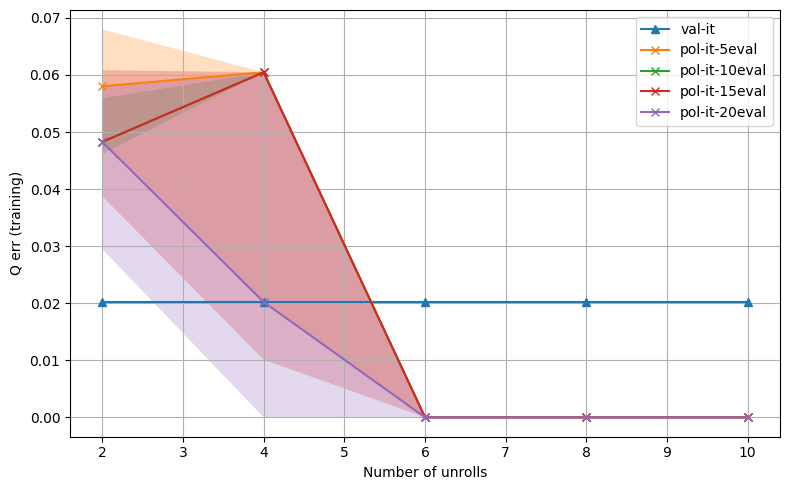

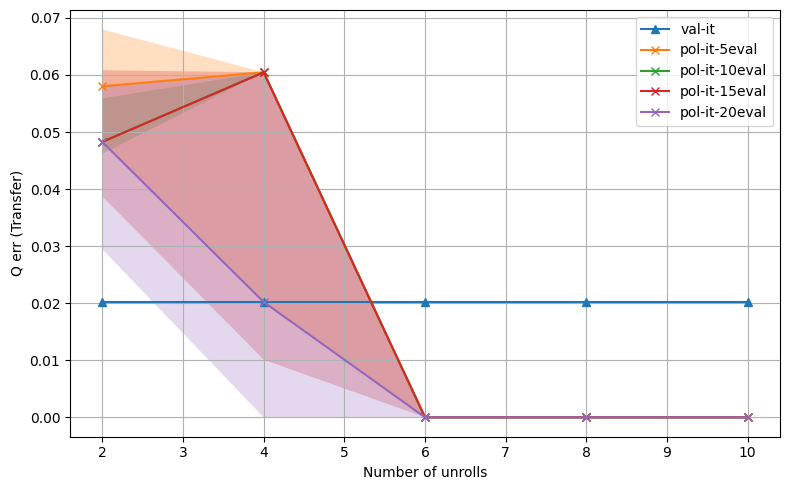

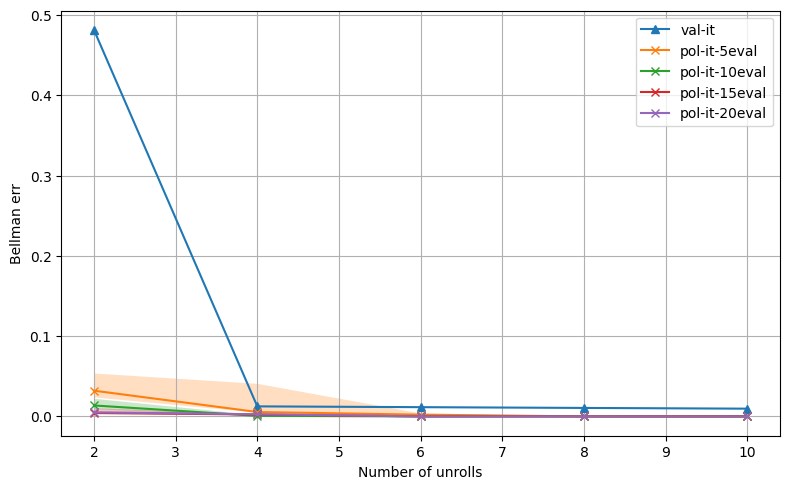

In [6]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs, N_unrolls, Exps, xlabel, "Q err (training)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs_trans, N_unrolls, Exps, xlabel, "Q err (Transfer)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## K=10

In [ ]:
verbose = True
use_logger = True
log_every_n_steps = 1
K = 10
group_name = f"transfer-K{K}"
N_unrolls = np.arange(2,16, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},
    # {"model": "pol-it", "args": {"max_eval_iters": 20}, "name": "pol-it-20eval"},

    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(mirror_env=False, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)
q_opt_mirr = get_optimal_q(mirror_env=True, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/srey/Investigacion/rl-unrolling/checkpoints exists and is not empty.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in 

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 215.09it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]    

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 215.85it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 120.88it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


In [ ]:
n_runs = 5

errs = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs_trans = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs[g], errs_trans[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, q_opt_mirr, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs=errs, errs_trans=errs_trans, bell_errs=bell_errs)
    print("Data saved as:", file_name)

In [ ]:
# # Load data
# data = np.load(PATH + "transfer-K10_data.npz", allow_pickle=True)
# N_unrolls = data["N_unrolls"]
# Exps = data["Exps"]
# errs = data["errs"]
# errs_trans = data["errs_trans"]
# bell_errs = data["bell_errs"]

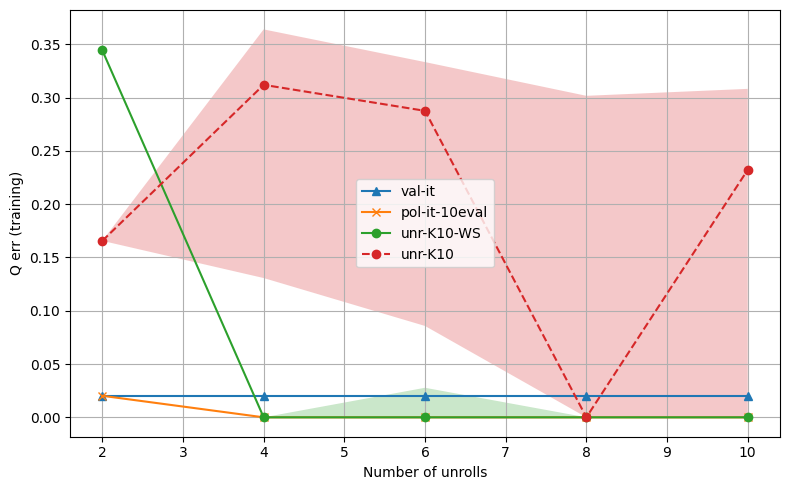

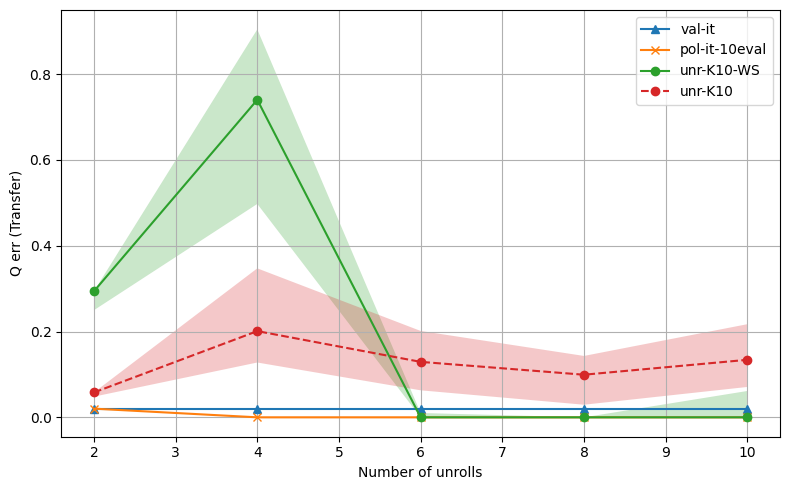

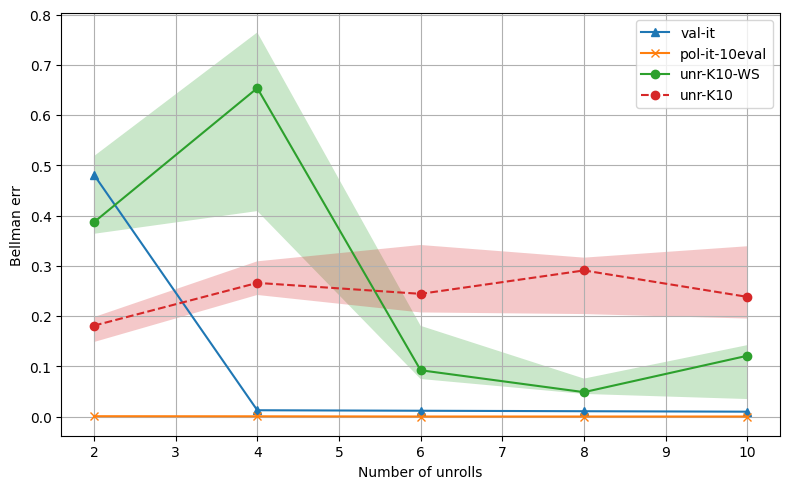

In [9]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs, N_unrolls, Exps, xlabel, "Q err (training)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs_trans, N_unrolls, Exps, xlabel, "Q err (Transfer)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## K=15

In [ ]:
verbose = True
use_logger = False
log_every_n_steps = 1
K = 15
group_name = f"transfer-K{K}"
N_unrolls = np.arange(2,16, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},
    # {"model": "pol-it", "args": {"max_eval_iters": 20}, "name": "pol-it-20eval"},

    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(mirror_env=False, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)
q_opt_mirr = get_optimal_q(mirror_env=True, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/srey/Investigacion/rl-unrolling/checkpoints exists and is not empty.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in 

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 215.09it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]    

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 215.85it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 120.88it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


In [ ]:
n_runs = 5

errs = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs_trans = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs[g], errs_trans[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, q_opt_mirr, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs=errs, errs_trans=errs_trans, bell_errs=bell_errs)
    print("Data saved as:", file_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 234.20it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 110.88it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 196.91it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 98.52it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 195.00it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 99.05it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICE

- 0. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 92.52it/s, reward_smoothness=0.980, bellman_error=26.50, loss=3.650] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 58.72it/s, reward_smoothness=0.980, bellman_error=26.50, loss=3.650]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 2: Model: unr-K5-WS Err1: 1.285 | bell_err: 0.035
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 81.82it/s, reward_smoothness=0.980, bellman_error=14.00, loss=1.020] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 54.24it/s, reward_smoothness=0.980, bellman_error=14.00, loss=1.020]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K10-WS Err1: 2.217 | bell_err: 0.017
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 242.92it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 105.46it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 5: Model: val-it Err1: 1.740 | bell_err: 0.018
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 236.97it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 103.38it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 5: Model: pol-it-5eval Err1: 1.139 | bell_err: 0.010
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 225.32it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 95.39it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 0. Unrolls 5: Model: pol-it-10eval Err1: 1.432 | bell_err: 0.005
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 67.19it/s, reward_smoothness=0.980, bellman_error=17.30, loss=1.570] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 46.69it/s, reward_smoothness=0.980, bellman_error=17.30, loss=1.570]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 5: Model: unr-K5-WS Err1: 0.950 | bell_err: 0.019
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 48.87it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.930]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 36.40it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.930]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 5: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.021
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 246.72it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 108.05it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 10: Model: val-it Err1: 0.996 | bell_err: 0.013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 241.48it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 107.28it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: pol-it-5eval Err1: 0.000 | bell_err: 0.005
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 237.77it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 105.76it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


- 0. Unrolls 10: Model: pol-it-10eval Err1: 0.723 | bell_err: 0.002



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 43.75it/s, reward_smoothness=0.980, bellman_error=12.10, loss=0.764] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 31.60it/s, reward_smoothness=0.980, bellman_error=12.10, loss=0.764]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 10: Model: unr-K5-WS Err1: 0.000 | bell_err: 0.013
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 34.82it/s, reward_smoothness=0.980, bellman_error=5.370, loss=0.150]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 26.67it/s, reward_smoothness=0.980, bellman_error=5.370, loss=0.150]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.006
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 181.72it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.28it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 190.42it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 96.82it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 183.43it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.19it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 1. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 98.81it/s, reward_smoothness=0.980, bellman_error=37.00, loss=7.140] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 64.58it/s, reward_smoothness=0.980, bellman_error=37.00, loss=7.140]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 2: Model: unr-K5-WS Err1: 1.909 | bell_err: 0.044
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 86.86it/s, reward_smoothness=0.980, bellman_error=13.40, loss=0.942] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 57.59it/s, reward_smoothness=0.980, bellman_error=13.40, loss=0.942]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: unr-K10-WS Err1: 0.128 | bell_err: 0.016
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 242.91it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 99.46it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 5: Model: val-it Err1: 1.740 | bell_err: 0.018
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 239.77it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 98.17it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 5: Model: pol-it-5eval Err1: 1.139 | bell_err: 0.010
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 237.56it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 97.36it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 1. Unrolls 5: Model: pol-it-10eval Err1: 1.432 | bell_err: 0.005
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 68.63it/s, reward_smoothness=0.980, bellman_error=14.30, loss=1.060] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 46.74it/s, reward_smoothness=0.980, bellman_error=14.30, loss=1.060]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 5: Model: unr-K5-WS Err1: 0.813 | bell_err: 0.016
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.940]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 37.27it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.940]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 5: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.021
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 240.09it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 112.71it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 10: Model: val-it Err1: 0.996 | bell_err: 0.013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 227.77it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 101.83it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 10: Model: pol-it-5eval Err1: 0.000 | bell_err: 0.005
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 225.14it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 101.66it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


- 1. Unrolls 10: Model: pol-it-10eval Err1: 0.723 | bell_err: 0.002


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 45.66it/s, reward_smoothness=0.980, bellman_error=47.90, loss=12.00]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s, reward_smoothness=0.980, bellman_error=47.90, loss=12.00]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 10: Model: unr-K5-WS Err1: 0.000 | bell_err: 0.044
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 31.29it/s, reward_smoothness=0.980, bellman_error=25.80, loss=3.460]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s, reward_smoothness=0.980, bellman_error=25.80, loss=3.460]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 10: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.025
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 182.56it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 93.88it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 2. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 190.27it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 95.97it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 2. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 185.92it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 95.43it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 2. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009
Epoch 1734:   0%|          | 0/1 [00:00<?, ?it/s, reward_smoothness=0.980, bellman_error=14.80, loss=1.150]         

In [ ]:
# # Load data
# data = np.load(PATH + "transfer-K15_data.npz", allow_pickle=True)
# N_unrolls = data["N_unrolls"]
# Exps = data["Exps"]
# errs = data["errs"]
# errs_trans = data["errs_trans"]
# bell_errs = data["bell_errs"]

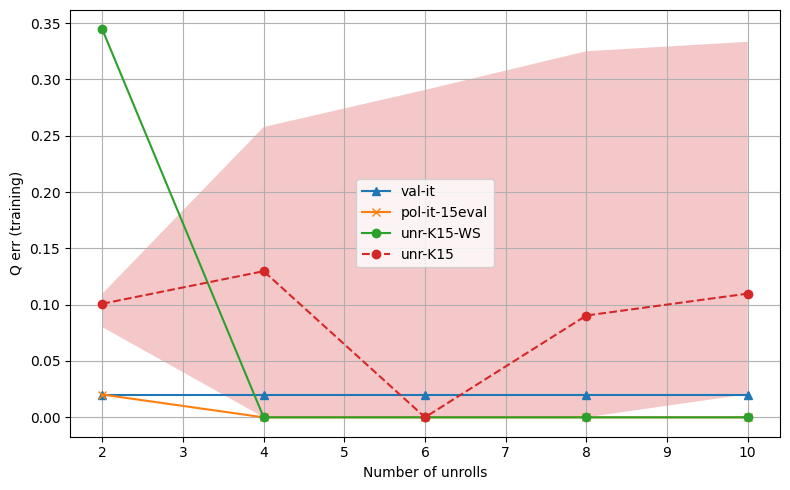

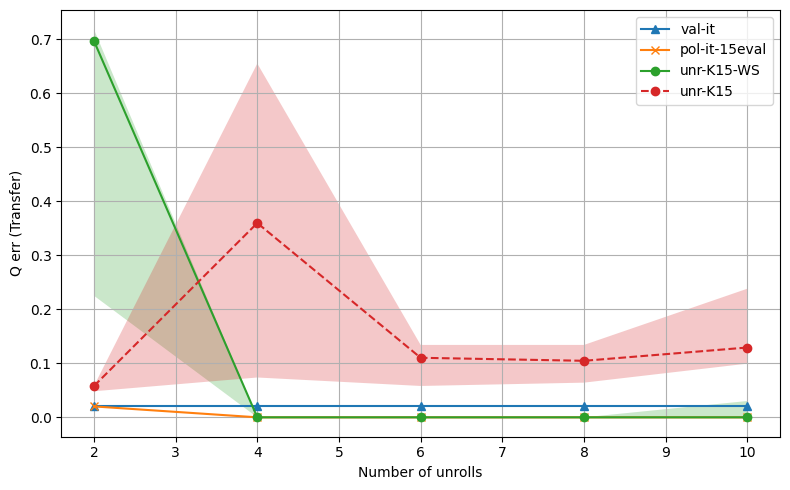

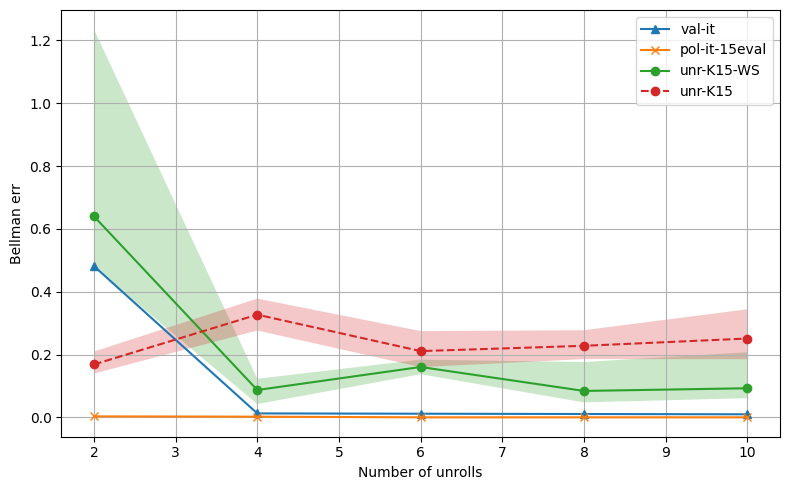

In [12]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs, N_unrolls, Exps, xlabel, "Q err (training)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs_trans, N_unrolls, Exps, xlabel, "Q err (Transfer)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## Plot All

In [13]:
# Load data
files = ["transfer-K5_data.npz", "transfer-K10_data.npz", "transfer-K15_data.npz"]

Exps = []
errs_list = []
errs_trans_list = []
bell_errs_list = []
for file in files:
    data = np.load(PATH + file, allow_pickle=True)
    
    if 'N_unrolls' not in locals():  # Save only once
        N_unrolls = data["N_unrolls"]
    
    Exps += list(data["Exps"])
    
    errs_list.append(data["errs"])
    errs_trans_list.append(data["errs_trans"])
    bell_errs_list.append(data["bell_errs"])

# Concatenate all data
errs = np.concatenate(errs_list, axis=1)
errs_trans = np.concatenate(errs_trans_list, axis=1)
bell_errs = np.concatenate(bell_errs_list, axis=1)

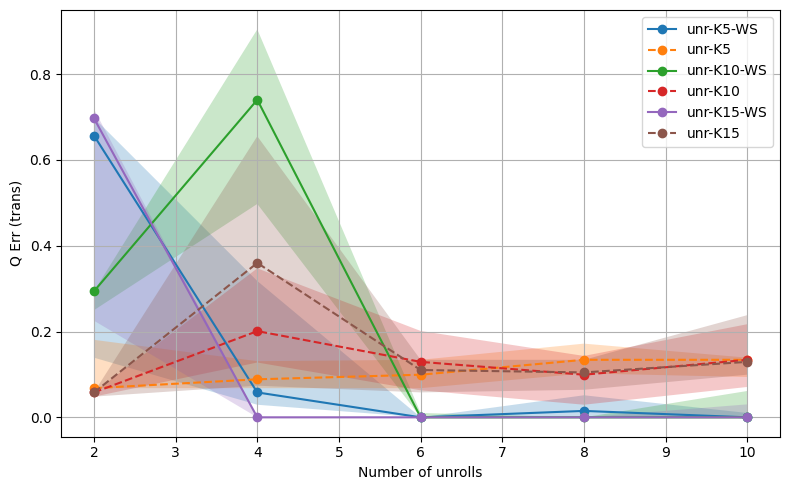

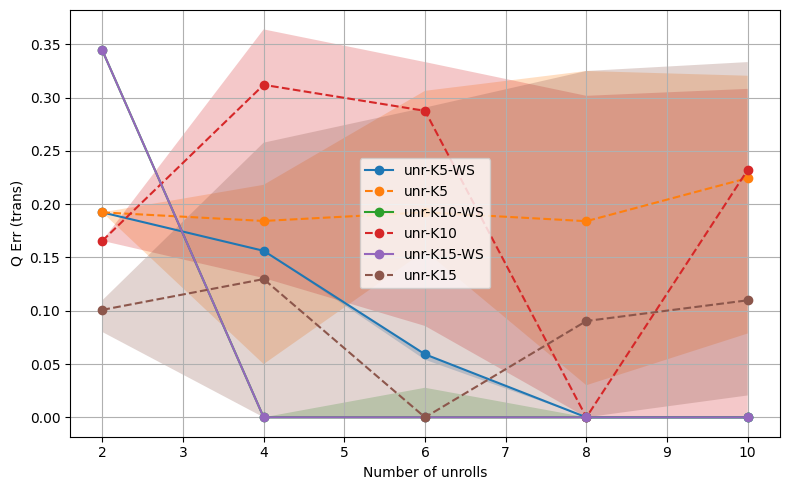

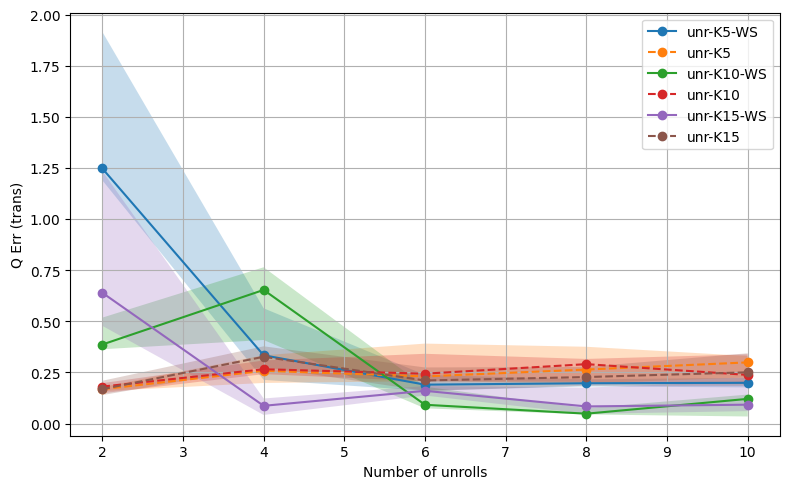

Data saved to csv file: results/transfer/n_unrolls_all_data_med_err.csv
Data saved to csv file: results/transfer/n_unrolls_all_data_prctile25.csv
Data saved to csv file: results/transfer/n_unrolls_all_data_prctile75.csv


In [15]:
# Indexes 0, 4 and 8 are all policy evaluation
skip_idx = [0, 1, 4, 5, 8, 9]
xlabel = "Number of unrolls"
plot_errors(errs_trans, N_unrolls, Exps, xlabel, "Q Err (trans)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs, N_unrolls, Exps, xlabel, "Q Err (trans)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Q Err (trans)", skip_idx=skip_idx, agg="median", deviation='prctile')

if SAVE:
    file_name = PATH + "n_unrolls_all_data_med_err.csv"
    save_error_matrix_to_csv(np.median(errs_trans, axis=0), N_unrolls, Exps, file_name)
    file_name = PATH + "n_unrolls_all_data_prctile25.csv"
    save_error_matrix_to_csv(np.percentile(errs_trans, 25, axis=0), N_unrolls, Exps, file_name)
    file_name = PATH + "n_unrolls_all_data_prctile75.csv"
    save_error_matrix_to_csv(np.percentile(errs_trans, 75, axis=0), N_unrolls, Exps, file_name)
